In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns

Some background:
With our dataset followed a link to information about the data (https://archive.ics.uci.edu/dataset/367/dota2+games+results). Under this link there is information that is needed to understand the dataset since originally the dataset had no column names. You can also find the following link which is a json that maps each hero to its actual name instead of just "hero1", "hero2" ... "heron"(https://github.com/kronusme/dota2-api/blob/master/data/heroes.json). We would like to be able to find what the different gamemodes and gametypes are also but this information was not available at either places. Further, the website with the dataset claimed that there were no missing values which we confirmed in Excel since we deemed it easier to use a more "visual" tool for that part.

In [3]:
file_path = './project_training.csv'
file_path2 = './project_test.csv'
json_map_path = './heroes.json'

Here we just merge the traing and test data so that we don't have to repeat each operation twice. We will of course split it again later.

In [5]:
df1 = pd.read_csv(file_path)
df2 = pd.read_csv(file_path2)
df = pd.concat([df1, df2], ignore_index=True)

In [6]:
# Open and read the JSON file
with open(json_map_path, 'r') as file:
    data = json.load(file)

# Convert the list of heroes to a DataFrame
df_json = pd.DataFrame(data['heroes'])

df_json.head()

,name,id,localized_name
0,antimage,1,Anti-Mage
1,axe,2,Axe
2,bane,3,Bane
3,bloodseeker,4,Bloodseeker
4,crystal_maiden,5,Crystal Maiden


In [7]:
num_rows = df1.shape[0]
num_rows1 = df2.shape[0]
num_rows2 = df.shape[0]
print(f"Number of rows in df1: {num_rows}")
print(f"Number of rows in df2: {num_rows1}")
print(f"Number of rows in df: {num_rows2}")

Number of rows in df1: 92650
Number of rows in df2: 10294
Number of rows in df: 102944


In [8]:
df.head()

,Win,clusterID,Gamemode,Gametype,hero1,hero2,hero3,hero4,hero5,hero6,...,hero104,hero105,hero106,hero107,hero108,hero109,hero110,hero111,hero112,hero113
0,1,111,9,2,0,0,−1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,−1,111,9,2,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
2,−1,111,9,2,1,0,0,0,0,0,...,−1,0,0,0,0,0,0,0,0,0
3,−1,111,9,2,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,−1,111,9,2,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


We map each hero to its actual name using the json file.

In [10]:
hero_id_to_name = dict(zip(df_json['id'], df_json['localized_name']))

# Create a dictionary for renaming columns
rename_columns = {}

# Iterate over the columns of df that start with 'hero'
for col in df.columns:
    if col.startswith('hero'):
        # Extract the number after 'hero'
        hero_id = int(col.replace('hero', ''))
        # Get the hero name from the mapping dictionary
        hero_name = hero_id_to_name.get(hero_id, f"Unknown-{hero_id}")
        # Map the original column name to the new one
        rename_columns[col] = hero_name

# Rename the columns using the mapping dictionary
df.rename(columns=rename_columns, inplace=True)

df.head()

,Win,clusterID,Gamemode,Gametype,Anti-Mage,Axe,Bane,Bloodseeker,Crystal Maiden,Drow Ranger,...,Legion Commander,Techies,Ember Spirit,Earth Spirit,Abyssal Underlord,Terrorblade,Phoenix,Oracle,Winter Wyvern,Arc Warden
0,1,111,9,2,0,0,−1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,−1,111,9,2,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
2,−1,111,9,2,1,0,0,0,0,0,...,−1,0,0,0,0,0,0,0,0,0
3,−1,111,9,2,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,−1,111,9,2,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [11]:
never_used_heroes = df.loc[:, df.drop(['Win', 'clusterID', 'Gamemode', 'Gametype'], axis=1).columns].apply(lambda x: (x == 0).all(), axis=0)
print(never_used_heroes[never_used_heroes == True])

Unknown-24           True
Abyssal Underlord    True
dtype: bool


Unknown-24 and abyssal Underlord seems to lack usage, hence we can remove them.

In [13]:
df = df.drop(['Unknown-24', 'Abyssal Underlord'], axis=1)

In [14]:
duplicate_rows = df[df.duplicated()]
print("Duplicate Rows:")
print(duplicate_rows.shape)

Duplicate Rows:
(0, 115)


In [15]:
print(df.dtypes)

Win              object
clusterID         int64
Gamemode          int64
Gametype          int64
Anti-Mage        object
                  ...  
Terrorblade      object
Phoenix          object
Oracle           object
Winter Wyvern    object
Arc Warden       object
Length: 115, dtype: object


Note how columns that should be int are object, lets fix that. Further, some negative signs need to be changed to the correct unicode representation for .replace() to recognize them.

In [17]:
df = df.replace({'\u2013': '-', '\u2212': '-'}, regex=True)

# Convert all columns to numeric (float or int) after fixing the dashes
df = df.apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)

In [18]:
for column in df.columns:
  print(f"Unique values in column '{column}':")
  print(df[column].unique())
  print("-" * 20)

Unique values in column 'Win':
[ 1 -1]
--------------------
Unique values in column 'clusterID':
[111 112 121 122 123 124 131 132 133 134 135 136 137 138 144 145 151 152
 153 154 155 156 161 171 181 182 183 184 185 186 187 188 191 192 204 211
 213 223 224 225 227 231 232 241 251 261 212]
--------------------
Unique values in column 'Gamemode':
[9 8 7 6 5 4 3 2 1]
--------------------
Unique values in column 'Gametype':
[2 1 3]
--------------------
Unique values in column 'Anti-Mage':
[ 0  1 -1]
--------------------
Unique values in column 'Axe':
[ 0  1 -1]
--------------------
Unique values in column 'Bane':
[-1  0  1]
--------------------
Unique values in column 'Bloodseeker':
[ 0  1 -1]
--------------------
Unique values in column 'Crystal Maiden':
[ 0 -1  1]
--------------------
Unique values in column 'Drow Ranger':
[ 0  1 -1]
--------------------
Unique values in column 'Earthshaker':
[ 0  1 -1]
--------------------
Unique values in column 'Juggernaut':
[ 0  1 -1]
----------------

Now, part of this project is web integration. For this we will have users input the heroes of both teams, and a result will be displayed. A problem arises since we do not have the mapping for gamemodes, gametypes or clusterID so we can not get that input from the user. For this reason we will remove them. First, let us make sure that they do not have strong correlation with the outcome of the match.

In [20]:

# Since both output classes represent a win which might cancel each other out, we create two columns representing the two teams instead.
df['Team1_Win'] = df['Win'].apply(lambda x: 1 if x == 1 else 0)
df['Team2_Win'] = df['Win'].apply(lambda x: 1 if x == -1 else 0)

# Compute the correlation matrix
correlation_matrix = df.corr()

print("Correlation of 'Team1_Win' with other variables:")
print(correlation_matrix['Team1_Win'][['Gamemode', 'Gametype', 'clusterID']])
print("\nCorrelation of 'Team2_Win' with other variables:")
print(correlation_matrix['Team2_Win'][['Gamemode', 'Gametype', 'clusterID']])

Correlation of 'Team1_Win' with other variables:
Gamemode     0.001003
Gametype    -0.000822
clusterID    0.000085
Name: Team1_Win, dtype: float64

Correlation of 'Team2_Win' with other variables:
Gamemode    -0.001003
Gametype     0.000822
clusterID   -0.000085
Name: Team2_Win, dtype: float64


This confirms that it is unlikely that those columns have any effect on the outcome of the match. Hence, we will remove them. Keep in mind, if we had access to the mapping we might have kept them but this is not possible. And since we do not know the mapping, we can not use them with production data in a later stage. If we eventually create a website we will only be able to handle input for the heroes.

In [22]:
df = df.drop(['Gamemode', 'Gametype', 'clusterID', 'Team1_Win', 'Team2_Win'], axis=1)
df.head()

,Win,Anti-Mage,Axe,Bane,Bloodseeker,Crystal Maiden,Drow Ranger,Earthshaker,Juggernaut,Mirana,...,Elder Titan,Legion Commander,Techies,Ember Spirit,Earth Spirit,Terrorblade,Phoenix,Oracle,Winter Wyvern,Arc Warden
0,1,0,0,-1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
2,-1,1,0,0,0,0,0,0,0,0,...,0,-1,0,0,0,0,0,0,0,0
3,-1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,-1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


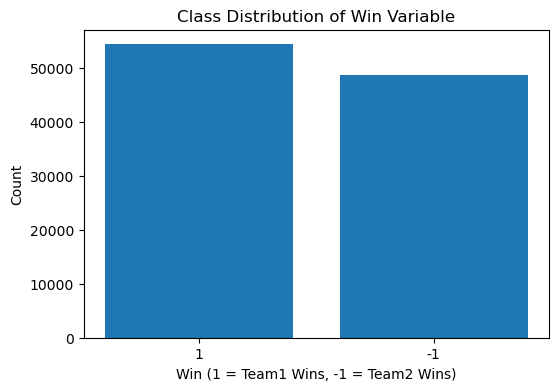

In [23]:
import matplotlib.pyplot as plt

# Count the occurrences of each class
class_counts = df['Win'].value_counts()

plt.figure(figsize=(6, 4))
plt.bar(class_counts.index.astype(str), class_counts.values)
plt.title('Class Distribution of Win Variable')
plt.xlabel('Win (1 = Team1 Wins, -1 = Team2 Wins)')
plt.ylabel('Count')
plt.show()

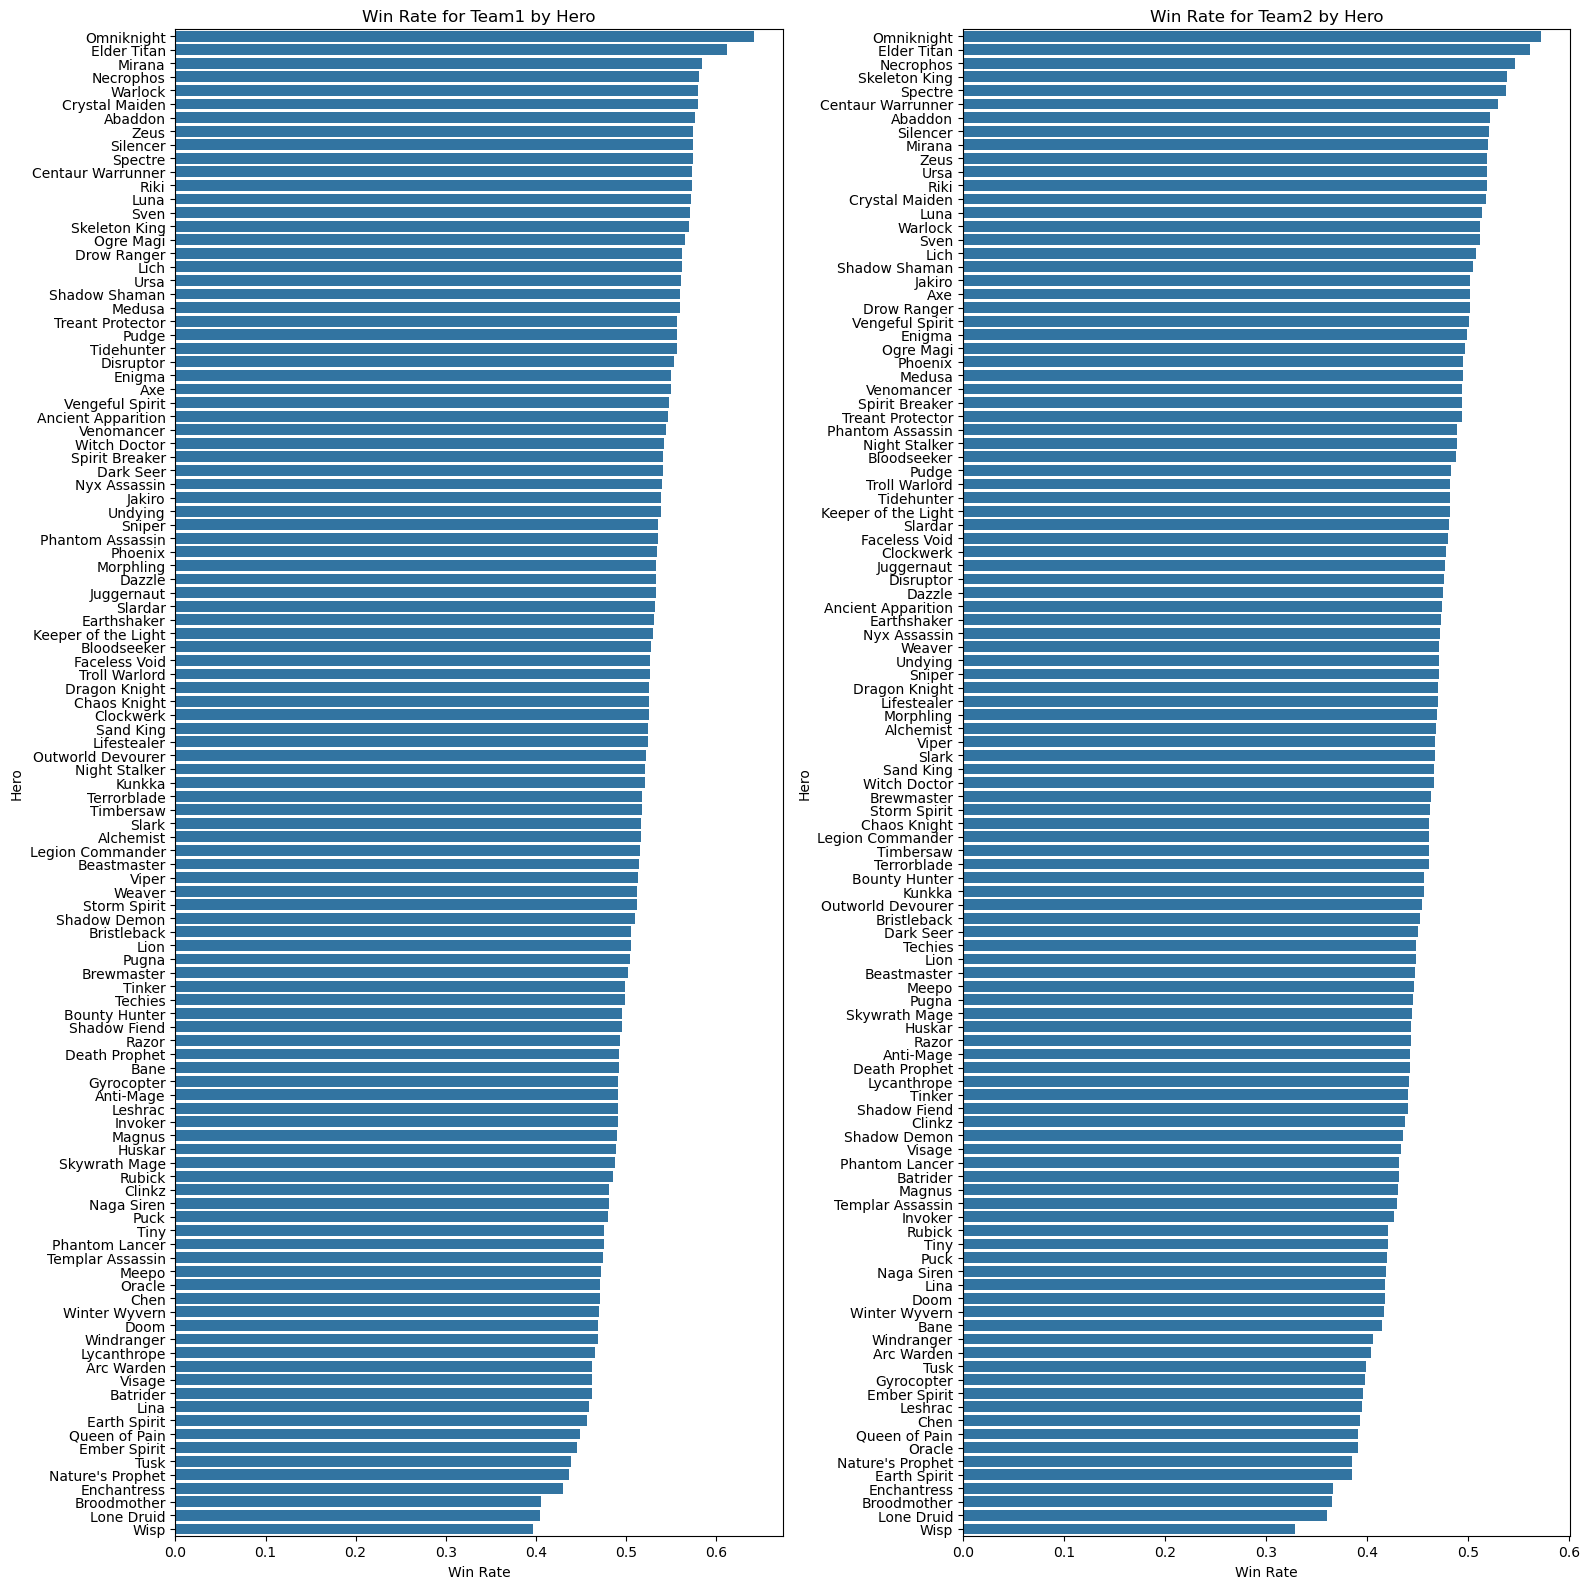

In [24]:
hero_columns = [col for col in df.columns if col not in ['Win', 'clusterID', 'Gamemode', 'Gametype']]

# Calculate win rates for each hero, considering both team1 and team2 wins
win_rates_team1 = {}
win_rates_team2 = {}

for hero in hero_columns:
    # Win rate when team1 picks the hero (hero == 1)
    team1_data = df[df[hero] == 1]
    win_rate_team1 = team1_data[team1_data['Win'] == 1].shape[0] / team1_data.shape[0] if team1_data.shape[0] > 0 else 0
    win_rates_team1[hero] = win_rate_team1

    # Win rate when team2 picks the hero (hero == -1)
    team2_data = df[df[hero] == -1]
    win_rate_team2 = team2_data[team2_data['Win'] == -1].shape[0] / team2_data.shape[0] if team2_data.shape[0] > 0 else 0
    win_rates_team2[hero] = win_rate_team2

# Convert to a sorted DataFrame for plotting
win_rates_df_team1 = pd.DataFrame(list(win_rates_team1.items()), columns=['Hero', 'Team1_WinRate']).sort_values(by='Team1_WinRate', ascending=False)
win_rates_df_team2 = pd.DataFrame(list(win_rates_team2.items()), columns=['Hero', 'Team2_WinRate']).sort_values(by='Team2_WinRate', ascending=False)

fig, ax = plt.subplots(1, 2, figsize=(16, 16))

sns.barplot(x='Team1_WinRate', y='Hero', data=win_rates_df_team1, ax=ax[0])
ax[0].set_title('Win Rate for Team1 by Hero')
ax[0].set_xlabel('Win Rate')
ax[0].set_ylabel('Hero')

sns.barplot(x='Team2_WinRate', y='Hero', data=win_rates_df_team2, ax=ax[1])
ax[1].set_title('Win Rate for Team2 by Hero')
ax[1].set_xlabel('Win Rate')
ax[1].set_ylabel('Hero')

plt.tight_layout()
plt.show()


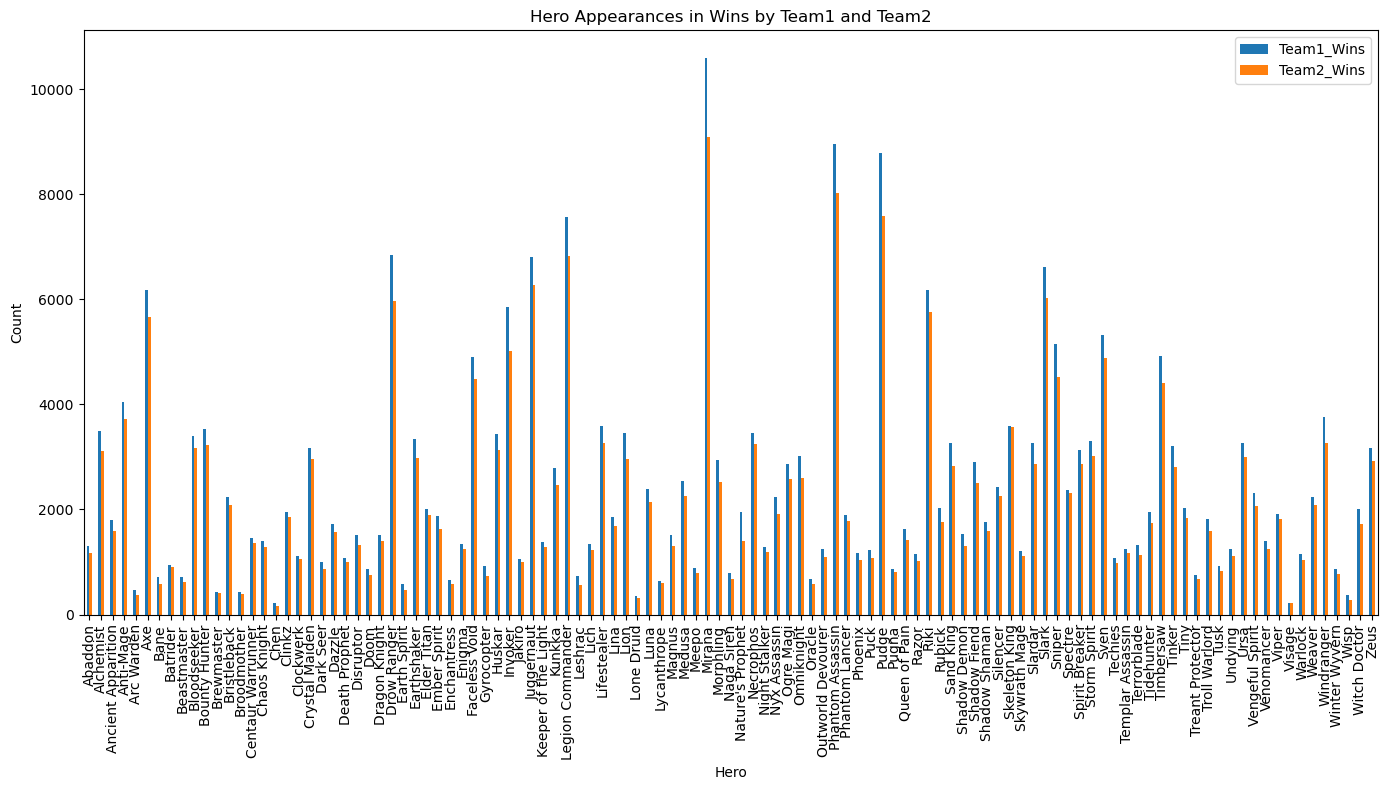

In [25]:
# Count occurrences of each hero for wins of team1 and team2
hero_win_counts_team1 = df[df['Win'] == 1][hero_columns].apply(lambda x: (x == 1).sum()).sort_values(ascending=False)
hero_win_counts_team2 = df[df['Win'] == -1][hero_columns].apply(lambda x: (x == -1).sum()).sort_values(ascending=False)

# Combine into a DataFrame for easy plotting
hero_win_counts = pd.DataFrame({
    'Team1_Wins': hero_win_counts_team1,
    'Team2_Wins': hero_win_counts_team2
})

hero_win_counts.plot(kind='bar', figsize=(14, 8))
plt.title('Hero Appearances in Wins by Team1 and Team2')
plt.xlabel('Hero')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


Again, it seems like certain heroes are better than others. Of course we have to take into consideration which heroes are popular and which are not since that will affect these plots. Let's look at that.

In [27]:
hero_pick_counts = {}

# Calculate how many times each hero was picked (either by Team1 or Team2)
for hero in hero_columns:
    # Count the number of games where the hero's value is either 1 or -1
    pick_count = df[hero].abs().sum()
    hero_pick_counts[hero] = pick_count

pick_counts_df = pd.DataFrame(list(hero_pick_counts.items()), columns=['Hero', 'Pick_Count'])

# Calculate the total number of games to determine the pick rate
total_games = df.shape[0]
pick_counts_df['Pick_Rate'] = (pick_counts_df['Pick_Count'] / total_games) * 100

# Sort by pick rate (descending)
pick_counts_df = pick_counts_df.sort_values(by='Pick_Rate', ascending=False)

# Display the heroes with the highest pick rate
print(pick_counts_df.to_string(index=False))


               Hero  Pick_Count  Pick_Rate
             Mirana       35582  34.564423
   Phantom Assassin       33143  32.195174
              Pudge       31469  30.569047
   Legion Commander       29445  28.602930
         Juggernaut       25934  25.192338
              Slark       25680  24.945601
        Drow Ranger       24069  23.380673
            Invoker       23689  23.011540
                Axe       22496  21.852658
               Riki       21878  21.252331
             Sniper       19193  18.644117
          Timbersaw       19086  18.540177
               Sven       18866  18.326469
      Faceless Void       18607  18.074876
          Anti-Mage       16605  16.130129
         Windranger       16080  15.620143
      Bounty Hunter       14158  13.753108
             Huskar       14086  13.683168
        Lifestealer       13772  13.378147
               Lion       13443  13.058556
          Alchemist       13394  13.010957
       Storm Spirit       12979  12.607826
        Blo

Let's look at the top 20% of picked heroes overall.

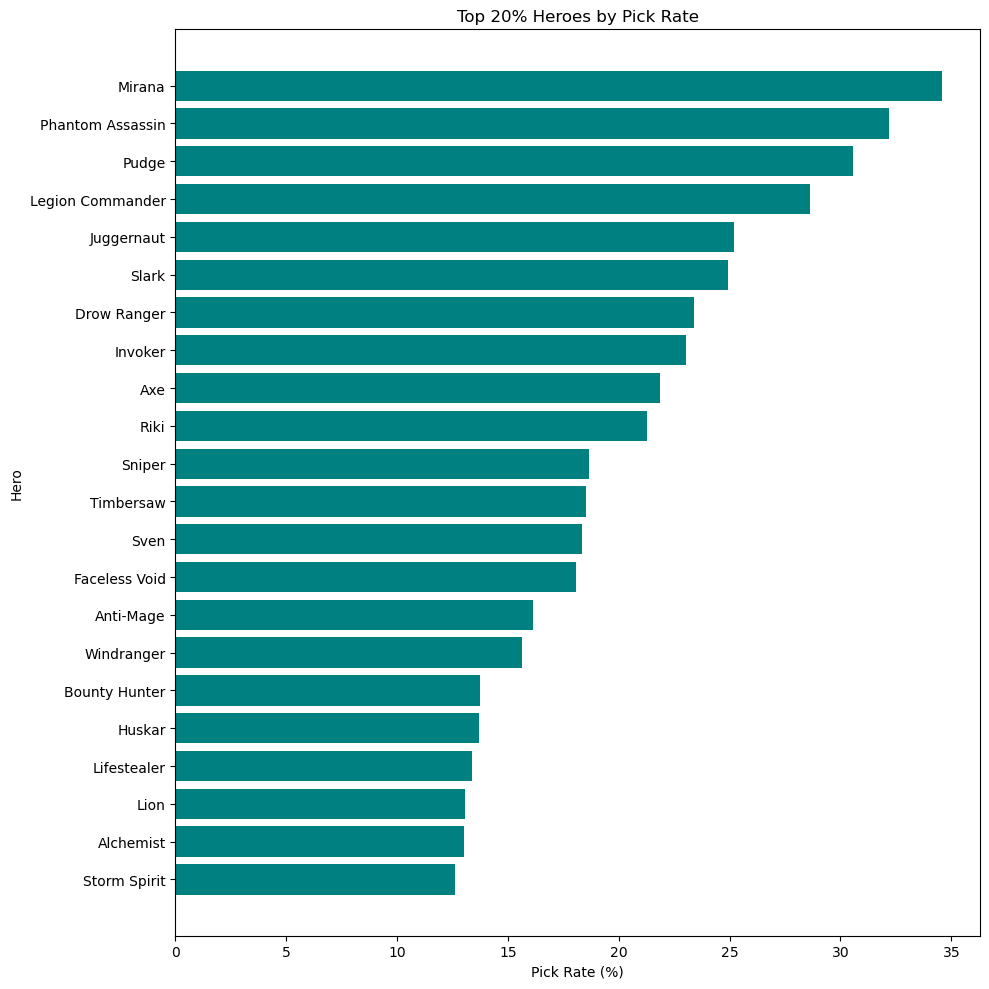

In [29]:
top_20_percent_count = int(len(pick_counts_df) * 0.2)

# Select the top 20% of heroes
top_20_percent_df = pick_counts_df.head(top_20_percent_count)

plt.figure(figsize=(10, 10))
plt.barh(top_20_percent_df['Hero'], top_20_percent_df['Pick_Rate'], color='teal')
plt.gca().invert_yaxis()
plt.xlabel('Pick Rate (%)')
plt.ylabel('Hero')
plt.title('Top 20% Heroes by Pick Rate')
plt.tight_layout()
plt.show()

We can see that this matches what we have seen in the other plots above. There is no clear hero/heroes that seem to always perform very well, rather heroes that appear in a lot of wins are just ones that are picked the most. 

           Hero  Pick_Rate    Win_Rate  Win_Pick_Ratio
64         Chen   0.867462  317.693169      366.232985
2          Bane   2.749067  577.950530      210.235121
90       Visage   0.965574  173.641851      179.832864
76   Brewmaster   1.693154  135.742972       80.171684
78   Lone Druid   1.698011  132.894737       78.264964
59  Broodmother   2.107942  153.225806       72.689758
36  Beastmaster   2.701469  193.311758       71.558021
89         Wisp   1.738809   98.268156       56.514621
50      Leshrac   2.843293  127.502562       44.843265
14        Razor   4.497591  167.473002       37.236157


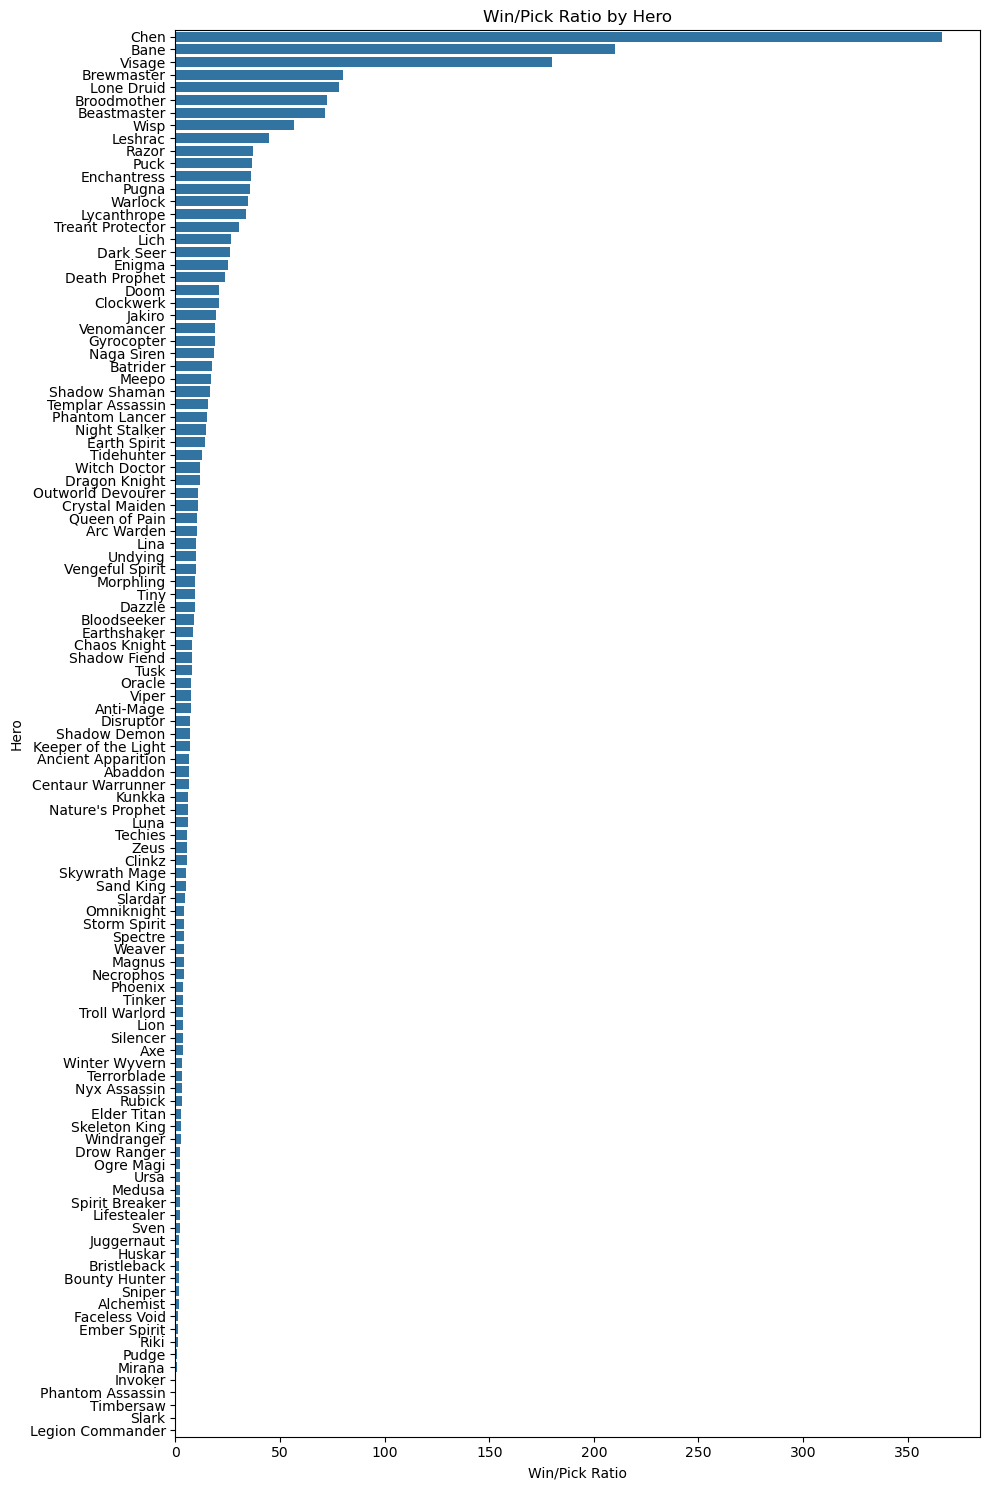

In [31]:
hero_stats_df = pd.DataFrame({
    'Hero': hero_pick_counts.keys(),
    'Pick_Count': hero_pick_counts.values(),
    'Team1_Wins': hero_win_counts_team1.values,
    'Team2_Wins': hero_win_counts_team2.values
})

# Total wins by each hero
hero_stats_df['Total_Wins'] = hero_stats_df['Team1_Wins'] + hero_stats_df['Team2_Wins']

# Calculate pick rate
hero_stats_df['Pick_Rate'] = (hero_stats_df['Pick_Count'] / total_games) * 100

# Calculate win rate
hero_stats_df['Win_Rate'] = (hero_stats_df['Total_Wins'] / hero_stats_df['Pick_Count']) * 100

# Calculate Win_rate/Pick_rate Ratio
hero_stats_df['Win_Pick_Ratio'] = hero_stats_df['Win_Rate'] / hero_stats_df['Pick_Rate']

# Sort by Win/Pick Ratio in descending order to see heroes that perform well when picked
hero_stats_df = hero_stats_df.sort_values(by='Win_Pick_Ratio', ascending=False)

# Display the top heroes by Win/Pick Ratio
print(hero_stats_df[['Hero', 'Pick_Rate', 'Win_Rate', 'Win_Pick_Ratio']].head(10))

plt.figure(figsize=(10,15))
sns.barplot(x='Win_Pick_Ratio', y='Hero', data=hero_stats_df)
plt.title('Win/Pick Ratio by Hero')
plt.xlabel('Win/Pick Ratio')
plt.ylabel('Hero')
plt.tight_layout()
plt.show()

Here we get some suggestions of some heroes that might be used less but still are powerful. We also see some of the heroes that have a high win rate, have a low win/pick ratio. Of course, that can be explained by the fact that a hero that is picked more will also lose/win more. It is worth noting that we are not experts in the field, there could be explanations to our plots that we are not aware of.

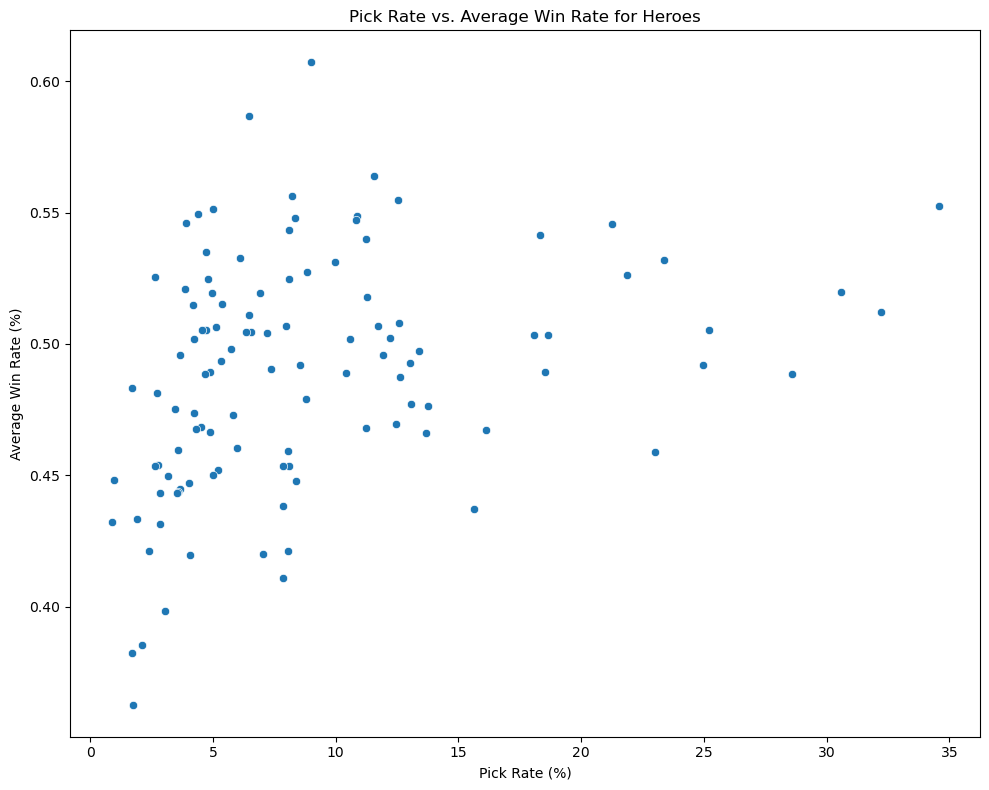

In [33]:
# Merge win rates and pick rates into a single DataFrame
hero_stats_df = pick_counts_df.merge(win_rates_df_team1, on='Hero').merge(win_rates_df_team2, on='Hero')

# Calculate the average win rate across both teams for each hero
hero_stats_df['Avg_Win_Rate'] = (hero_stats_df['Team1_WinRate'] + hero_stats_df['Team2_WinRate']) / 2

plt.figure(figsize=(10, 8))
sns.scatterplot(x='Pick_Rate', y='Avg_Win_Rate', data=hero_stats_df)

plt.xlabel('Pick Rate (%)')
plt.ylabel('Average Win Rate (%)')
plt.title('Pick Rate vs. Average Win Rate for Heroes')
plt.tight_layout()
plt.show()

This plot gives us some information about how heroes perform in relation to how often they are picked. We can see a wider spread among heroes that are not picked very often, whereas heroes that are picked more often seem to have just a slightly higher win rate on average.

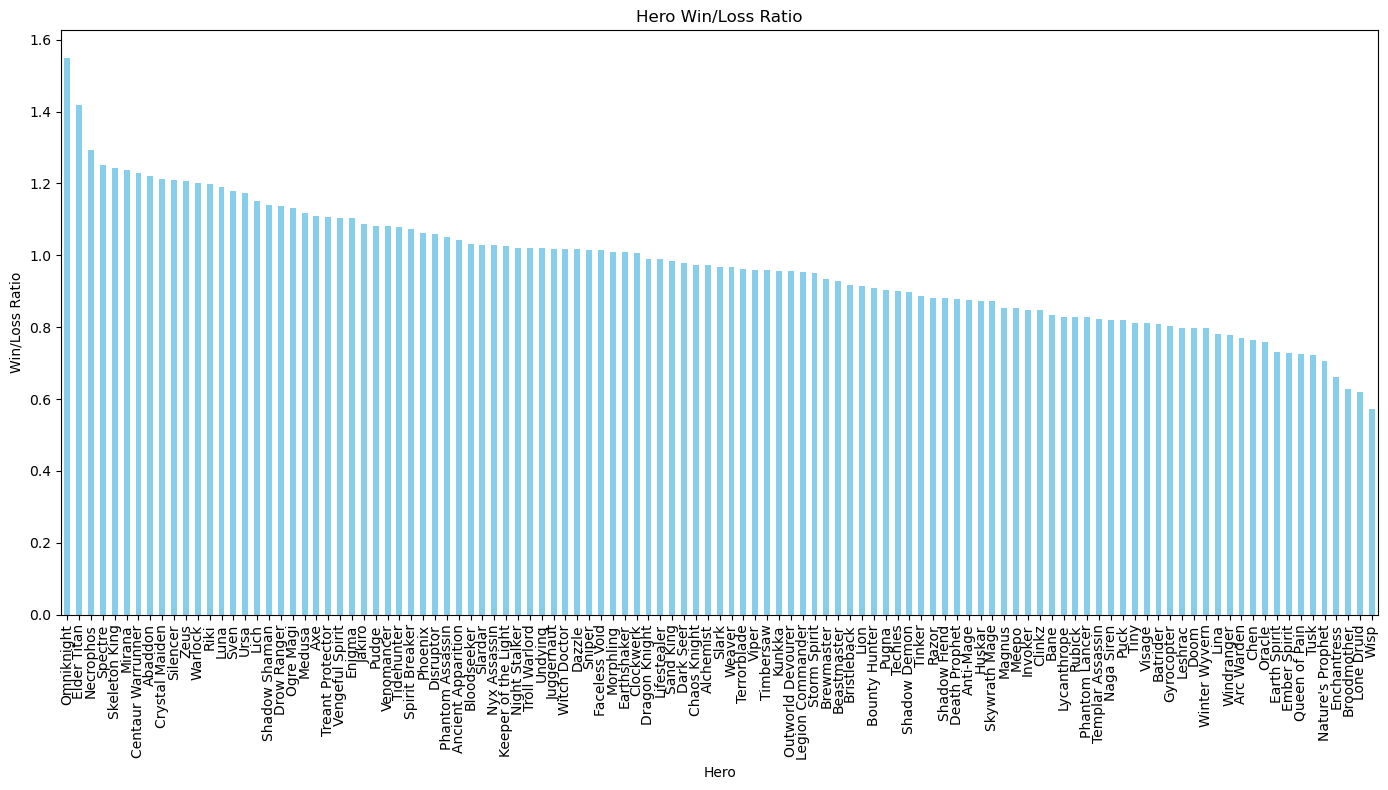

In [35]:
# Calculate win and loss counts for each hero
hero_win_counts_team1 = df[df['Win'] == 1][hero_columns].apply(lambda x: (x == 1).sum())
hero_win_counts_team2 = df[df['Win'] == -1][hero_columns].apply(lambda x: (x == -1).sum())
hero_loss_counts_team1 = df[df['Win'] == -1][hero_columns].apply(lambda x: (x == 1).sum())
hero_loss_counts_team2 = df[df['Win'] == 1][hero_columns].apply(lambda x: (x == -1).sum())

# Total wins and losses for each hero
hero_total_wins = hero_win_counts_team1 + hero_win_counts_team2
hero_total_losses = hero_loss_counts_team1 + hero_loss_counts_team2

hero_win_loss_ratio = hero_total_wins / hero_total_losses.replace(0, pd.NA)

plt.figure(figsize=(14, 8))
hero_win_loss_ratio.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Hero Win/Loss Ratio')
plt.xlabel('Hero')
plt.ylabel('Win/Loss Ratio')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Now we have plotted several graphs/plots. We definately see trends where some heroes are more popular than others, and they appear in more of the wins. However, from the plots it seems unlikely that we have certain heroes that significantly increases the chance of winning. This makes sense since videogame outcomes often correlate strongly with the individual skill of the player(s).

In [37]:
df['Win'] = df['Win'].replace(-1, 0)

Finally, let us also change the hero values into textual categorical representation for now. Only reason that we do this is to check if certain team combinations are very common, and if so, we have to take that into consideration.

In [39]:
# Dictionary to map numeric values to text values
mapping = {
    1: "team1",
    0: "no team",
    -1: "team2"
}
hero_columns = df.columns.difference(['Win'])
df_text_heroes = df[hero_columns].replace(mapping)
df_text_heroes['Win'] = df['Win']

columns = ['Win'] + [col for col in df_text_heroes.columns if col != 'Win']
df_text_heroes = df_text_heroes[columns]

df_text_heroes.head(20)

,Win,Abaddon,Alchemist,Ancient Apparition,Anti-Mage,Arc Warden,Axe,Bane,Batrider,Beastmaster,...,Venomancer,Viper,Visage,Warlock,Weaver,Windranger,Winter Wyvern,Wisp,Witch Doctor,Zeus
0,1,no team,no team,team2,no team,no team,no team,team2,no team,no team,...,no team,no team,no team,no team,no team,no team,no team,no team,no team,no team
1,0,no team,no team,team1,no team,no team,no team,no team,no team,no team,...,no team,no team,no team,no team,team2,no team,no team,no team,no team,no team
2,0,no team,no team,no team,team1,no team,no team,no team,no team,no team,...,no team,no team,no team,no team,no team,no team,no team,no team,no team,no team
3,0,no team,no team,no team,no team,no team,no team,no team,no team,team2,...,no team,team2,no team,no team,team2,no team,no team,no team,no team,no team
4,0,no team,no team,no team,no team,no team,no team,no team,no team,no team,...,no team,no team,no team,no team,no team,no team,no team,no team,no team,no team
5,1,no team,no team,no team,no team,no team,no team,no team,no team,no team,...,no team,no team,no team,no team,no team,no team,no team,no team,no team,no team
6,1,no team,no team,no team,team1,no team,no team,no team,no team,team1,...,no team,no team,no team,no team,no team,no team,no team,no team,no team,no team
7,1,no team,no team,no team,no team,no team,team1,no team,team2,no team,...,team1,no team,no team,no team,no team,no team,no team,no team,no team,no team
8,0,no team,team1,no team,no team,no team,no team,no team,no team,no team,...,no team,no team,no team,no team,no team,no team,no team,no team,no team,no team
9,0,no team,no team,no team,team2,no team,no team,team1,no team,team2,...,no team,team2,no team,no team,no team,no team,no team,no team,no team,no team


In [40]:
# Hero columns (exclude 'Win' column)
hero_columns = df_text_heroes.columns.difference(['Win'])

# Initialize new columns for the team hero lists
df_text_heroes['team1_heroes'] = df_text_heroes.apply(
    lambda row: [hero for hero in hero_columns if row[hero] == 'team1'], axis=1
)
df_text_heroes['team2_heroes'] = df_text_heroes.apply(
    lambda row: [hero for hero in hero_columns if row[hero] == 'team2'], axis=1
)

# Drop the individual hero columns since we only want the Win, team1_heroes, and team2_heroes columns
df_text_heroes = df_text_heroes[['Win', 'team1_heroes', 'team2_heroes']]
df_text_heroes.head()

,Win,team1_heroes,team2_heroes
0,1,"[Gyrocopter, Night Stalker, Nyx Assassin, Shad...","[Ancient Apparition, Bane, Luna, Sniper, Tiny]"
1,0,"[Ancient Apparition, Kunkka, Oracle, Spectre, ...","[Skywrath Mage, Tidehunter, Tusk, Ursa, Weaver]"
2,0,"[Anti-Mage, Bounty Hunter, Leshrac, Lifesteale...","[Centaur Warrunner, Faceless Void, Gyrocopter,..."
3,0,"[Death Prophet, Enigma, Lycanthrope, Shadow Sh...","[Beastmaster, Luna, Puck, Viper, Weaver]"
4,0,"[Dragon Knight, Legion Commander, Morphling, S...","[Centaur Warrunner, Faceless Void, Magnus, Que..."


We did the step above and below to perhaps see if certain combinations of heroes are more common than others, evidently they are not. Hence we will not move further with this. Instead we will keep the original format to increase the chance of our model capturing individual influence of heroes on the outcome.

In [42]:
unique_team1_combinations = df_text_heroes['team1_heroes'].apply(tuple).nunique()
unique_team2_combinations = df_text_heroes['team2_heroes'].apply(tuple).nunique()

print("Number of unique hero combinations for Team 1:", unique_team1_combinations)
print("Number of unique hero combinations for Team 2:", unique_team2_combinations)

Number of unique hero combinations for Team 1: 102241
Number of unique hero combinations for Team 2: 102268


The dataset is already encoded. We will just continue with the dataframe we had from the beginning. In the end, the data exploration/visualization did not lead to any major changes but we did get a good idea of what to expect from our models. That is, we might have difficulties generalizing well. We will thus focus on models that have a higher chance of capturing more complex patterns that we might have missed.

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Define scoring metrics for cross-validation
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),  # weighted for multi-class
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
}


X = df.drop('Win', axis=1)  # Features
y = df['Win']               # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (82355, 111)
X_test shape: (20589, 111)
y_train shape: (82355,)
y_test shape: (20589,)


We will try the SGDClassifier from scikit first. The reason behind this choice is simply that it is the recomendation from scikit:
https://scikit-learn.org/stable/machine_learning_map.html

Mean Accuracy: 0.5804262036306236
Mean Precision: 0.59338821983506
Mean Recall: 0.6579519419092403
Mean F1 Score: 0.6222792839985811


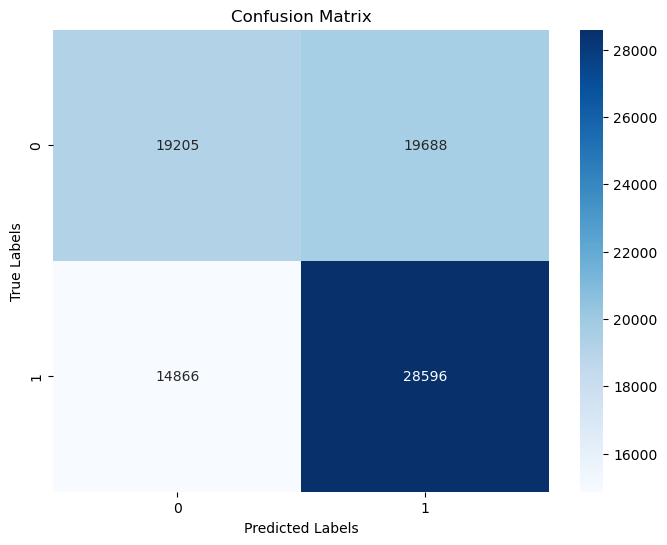

In [46]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate, cross_val_predict

# Initialize the classifier
sgd_clf = SGDClassifier(loss='squared_error', random_state=42, max_iter=1000, tol=1e-3)

# Perform cross-validation
cv_results = cross_validate(sgd_clf, X_train, y_train, cv=5, scoring=scoring)

# Cross-validated predictions for confusion matrix
y_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=5)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_train, y_pred)

# Print cross-validation results
print("Mean Accuracy:", cv_results['test_accuracy'].mean())
print("Mean Precision:", cv_results['test_precision'].mean())
print("Mean Recall:", cv_results['test_recall'].mean())
print("Mean F1 Score:", cv_results['test_f1'].mean())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

The sgd classifier struggles with distinguishing between the two classes, we see high numbers of both false positives and false negatives. Next we will try a random forest classifier to see if it can better capture patterns in our data.

Mean Accuracy: 0.5740149353409022
Mean Precision: 0.5869673721636717
Mean Recall: 0.6505915307390107
Mean F1 Score: 0.617136644416435


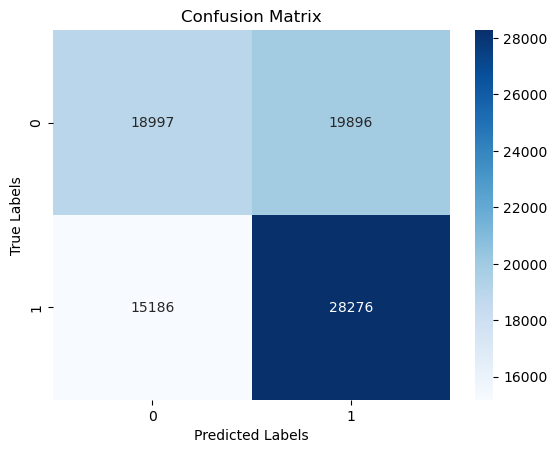

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

rf_clf = RandomForestClassifier(random_state=42)

cv_results = cross_validate(rf_clf, X_train, y_train, cv=5, scoring=scoring, return_train_score=False)

# Cross-validated predictions for confusion matrix
y_pred = cross_val_predict(rf_clf, X_train, y_train, cv=5)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_train, y_pred)

print("Mean Accuracy:", np.mean(cv_results['test_accuracy']))
print("Mean Precision:", np.mean(cv_results['test_precision']))
print("Mean Recall:", np.mean(cv_results['test_recall']))
print("Mean F1 Score:", np.mean(cv_results['test_f1']))

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

As we can see, the random forest classifier seems to struggle in the same way as our sgd classifier. Both of them seem to slighter favor one team but it is not by a lot. We will now try a boosted model, and hopefully we will see some improved performance. We will also introduce some balancing, even though we have a quite balanced class distribution, since both of these models slightly favor one team over the other.

Mean Accuracy: 0.5834618420253779
Mean Precision: 0.6094222180096176
Mean Recall: 0.5867654304374155
Mean F1 Score: 0.5978752813720265


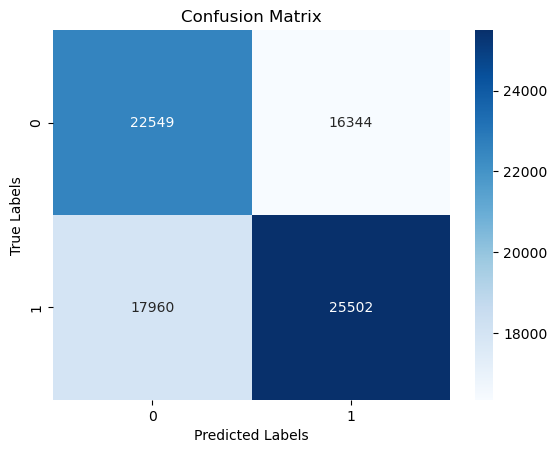

Model saved as 'basic_model.pkl'


In [52]:
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss, balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import cross_validate, cross_val_predict
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the model with class weight adjustment
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
xgb_clf = XGBClassifier(eval_metric='logloss', random_state=42, scale_pos_weight=scale_pos_weight)

# Perform cross-validation to evaluate metrics
scoring = ['accuracy', 'precision', 'recall', 'f1']
cv_results = cross_validate(xgb_clf, X_train, y_train, cv=5, scoring=scoring, return_train_score=False)

# Cross-validated predictions for confusion matrix
y_pred = cross_val_predict(xgb_clf, X_train, y_train, cv=5)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_train, y_pred)

# Display metrics
print("Mean Accuracy:", np.mean(cv_results['test_accuracy']))
print("Mean Precision:", np.mean(cv_results['test_precision']))
print("Mean Recall:", np.mean(cv_results['test_recall']))
print("Mean F1 Score:", np.mean(cv_results['test_f1']))

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Now, fit xgb_clf on the entire training dataset
xgb_clf.fit(X_train, y_train)

# Assign the fully trained model to basic_model
basic_model = xgb_clf

# Save the model as a .pkl file
with open("basic_model.pkl", "wb") as f:
    pickle.dump(basic_model, f)

print("Model saved as 'basic_model.pkl'")


The performance of xgboost is similar to that of the previous two. An important difference however is that it seems to be slightly better at not favoring one team over the other which is good for our purpose. However, it is still not the performance we are looking for so we will try to improve the performance of this model with a randomized search.

In [54]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4]
}

scorer = make_scorer(f1_score)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid,
    scoring=scorer,
    cv=5,  # 5-fold cross-validation
    n_iter=50,  # Number of different combinations to try
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X, y)

# Display the best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best F1 Score:", random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.6}
Best F1 Score: 0.6070638268704522


Cross-Validation Results with Best Model:
Mean Accuracy: 0.5940744338534394
Mean Precision: 0.6209759942627556
Mean Recall: 0.5923564585265695
Mean F1 Score: 0.6063172163603451


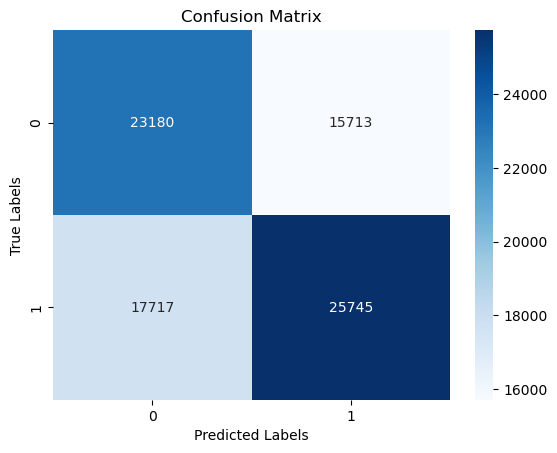

Model saved as 'best_model.pkl'


In [55]:

scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

best_model = random_search.best_estimator_

cv_results = cross_validate(
    best_model, X_train, y_train, cv=5, scoring=scoring, return_train_score=False
)

print("Cross-Validation Results with Best Model:")
print("Mean Accuracy:", np.mean(cv_results['test_accuracy']))
print("Mean Precision:", np.mean(cv_results['test_precision']))
print("Mean Recall:", np.mean(cv_results['test_recall']))
print("Mean F1 Score:", np.mean(cv_results['test_f1']))

# Cross-validated predictions for confusion matrix
y_pred = cross_val_predict(best_model, X_train, y_train, cv=5)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_train, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
import pickle

# Save the best model as a .pkl file
with open("best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

print("Model saved as 'best_model.pkl'")


In [56]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]  # Probability of the positive class (assuming binary classification)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
log_loss_value = log_loss(y_test, y_proba)

print("Test Data Metrics with Best Model:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC-ROC:", roc_auc)

Test Data Metrics with Best Model:
Accuracy: 0.6167856622468308
Precision: 0.6413693346190935
Recall: 0.6145814082424691
F1 Score: 0.6276896942242356
AUC-ROC: 0.6630074290381902


As we can see above, the optimization only gave the slightest improvement in performance. We believe that the cause for this might be that hero picks in Dota 2 might not be a very strong predictor of whether a game is won or not.

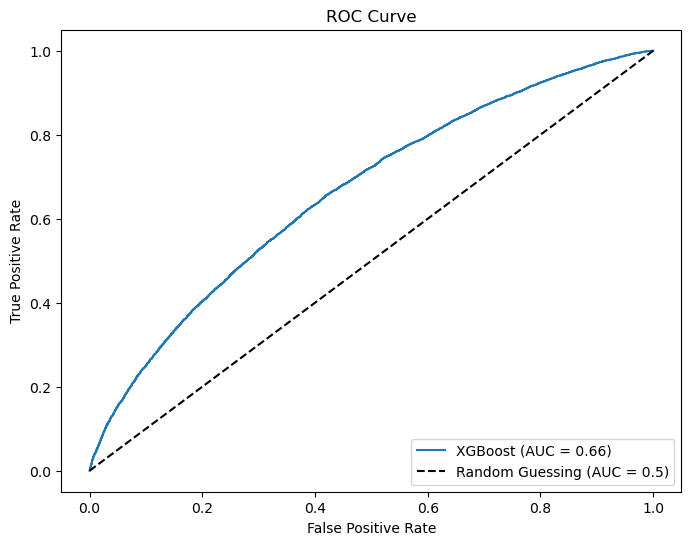

In [58]:
from sklearn.metrics import roc_curve, roc_auc_score
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calculate AUC
auc = roc_auc_score(y_test, y_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In the end we did not get the results that we had hoped for. However, we tried different models, with different algorithms but to no avail. We have brought up our concerns earlier, and we will discuss it further in our report.